In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import sisr
import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

In [2]:
# Removing negative values from model output after rescaling.
def neg_to_zero(arr):
  arr = np.squeeze(arr)
  return np.where(arr<0, 0, arr)

# To rescale data using the scaling factors used in standardizing.
def rescaler(arr):
  return np.squeeze(arr)*scaling_factors.at['Rainfall', 'Standard Dev.']+scaling_factors.at['Rainfall', 'Mean']

# Standard function to load and save model and its predicted output (rescaled) in a dictionary.
def model_load_and_predict(model = 'SRCNN'):
  model = tf.keras.models.load_model('../MODEL_RUNS/EXP001_'+model+'/EXP001_'+model+'_best_model.h5', compile = False)
  output = neg_to_zero(rescaler(model.predict(testing_data['lr_inputs'])[:,:,:,0]))
  return model, output

In [3]:
testing_data = np.load('../DATA/Testing_2016-2021_Scaled.npz',  allow_pickle=True)

# Loading the scaling factors to destandardize the output values.
scaling_factors = pd.DataFrame(testing_data['scaling_factors'],columns = ['Mean', 'Standard Dev.'], \
                               index = ['Rainfall', 'Topography', 'Net Wind'])

inputs = rescaler(testing_data['lr_inputs'][:,:,:,0]) # Low-resolution 1.00 degree RF inputs.
groundtruths = rescaler(testing_data['hr_outputs'][:,:,:,0]) # High-resolution 0.25 degree RF ground-truth data, provided by IMD.

# Loading mask file
mask_025 = np.load('../DATA/masks.npz')['mask_025']
mask_100 = np.load('../DATA/masks.npz')['mask_100']

models, outputs = {}, {}
# Bicubic interpolated output achieved using Climate Data Operators on the original low-resolution netCDF file (using 'remapbic' command). 
outputs['BICUBIC'] = neg_to_zero(xr.open_dataset('/content/C-G_IMD_SISR/DATA/RF_INTERPBIC_025_2016_2021.nc').rf.values)
for x in ['SRCNN', 'SRDRN', 'VDSR', 'AUTOENC', 'EDSR']:
  models[x], outputs[x] = model_load_and_predict(model = x)

# Loading other variables (for plotting purposes): Latitude, Longitude & Testing Dates ranges 
other = np.load('../DATA/other_variables.npz')

69/69 [==============================] - 4s 35ms/step


## **Plotting code**

In [4]:
# Selecting the timestep cases for qualitative analysis
# Criterion: More than 120 mm rainfall over 50% or more of the domain
percent = []
for _ in range(groundtruths.shape[0]):
  unique, counts = np.unique(groundtruths[_] > 120, return_counts=True)
  if counts.shape[0] == 1:
    percent.append(0)
  else:
    percent.append(counts[1]*100/(counts[0]+counts[1]))

percent = np.asarray(percent)
indexes = list(np.where(percent > 0.50)[0])
indexes

[588, 589, 590, 1314, 1315, 1316, 1317, 1318, 2030, 2083]

<ipython-input-5-68abe7d011e2>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


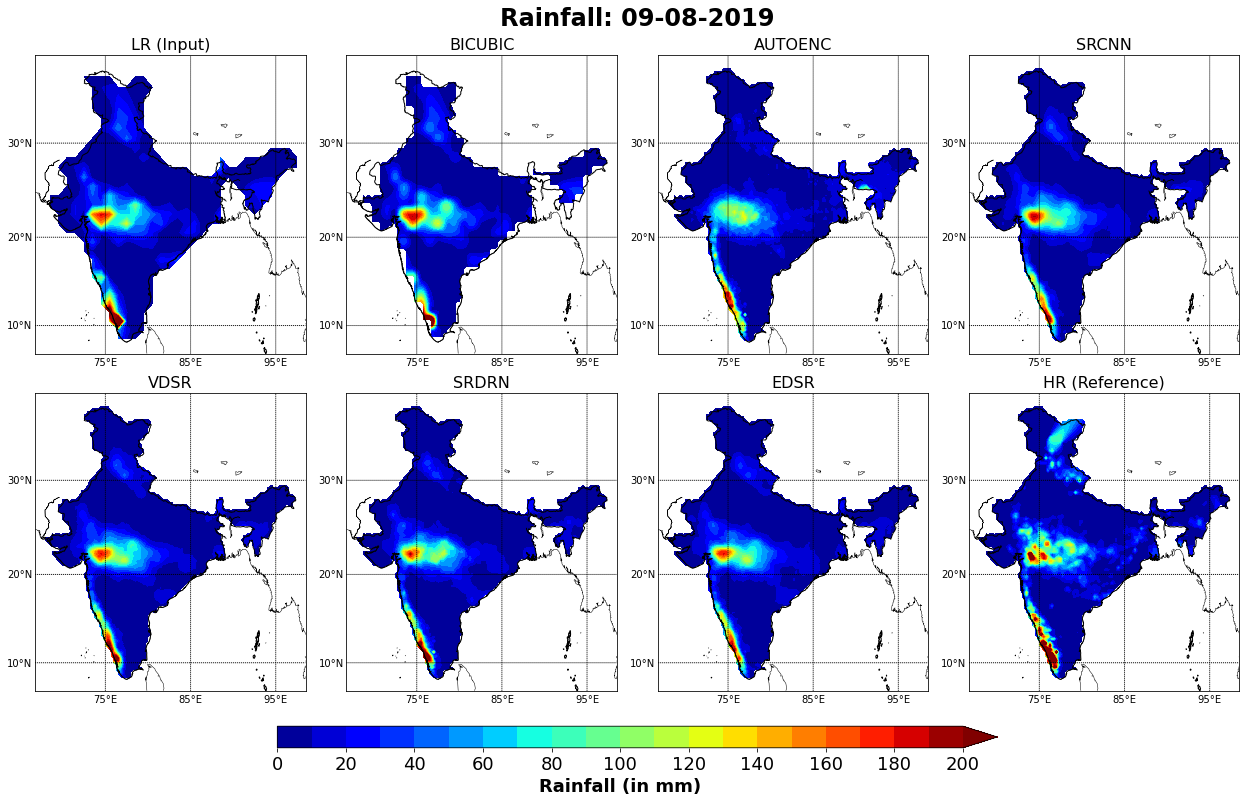

In [5]:
# Plotting code for Figure-5 a)
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1316
fig= plt.figure(figsize=(20,10), facecolor = 'white')

fig.suptitle('Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
            fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
    ax = fig.add_subplot(subplot)
    ax.set_title(x, fontsize=16)
    bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
    bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
    bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
    bm.drawcoastlines(linewidth=0.5)
    bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
    subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()   

<ipython-input-6-cddb0190b72c>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


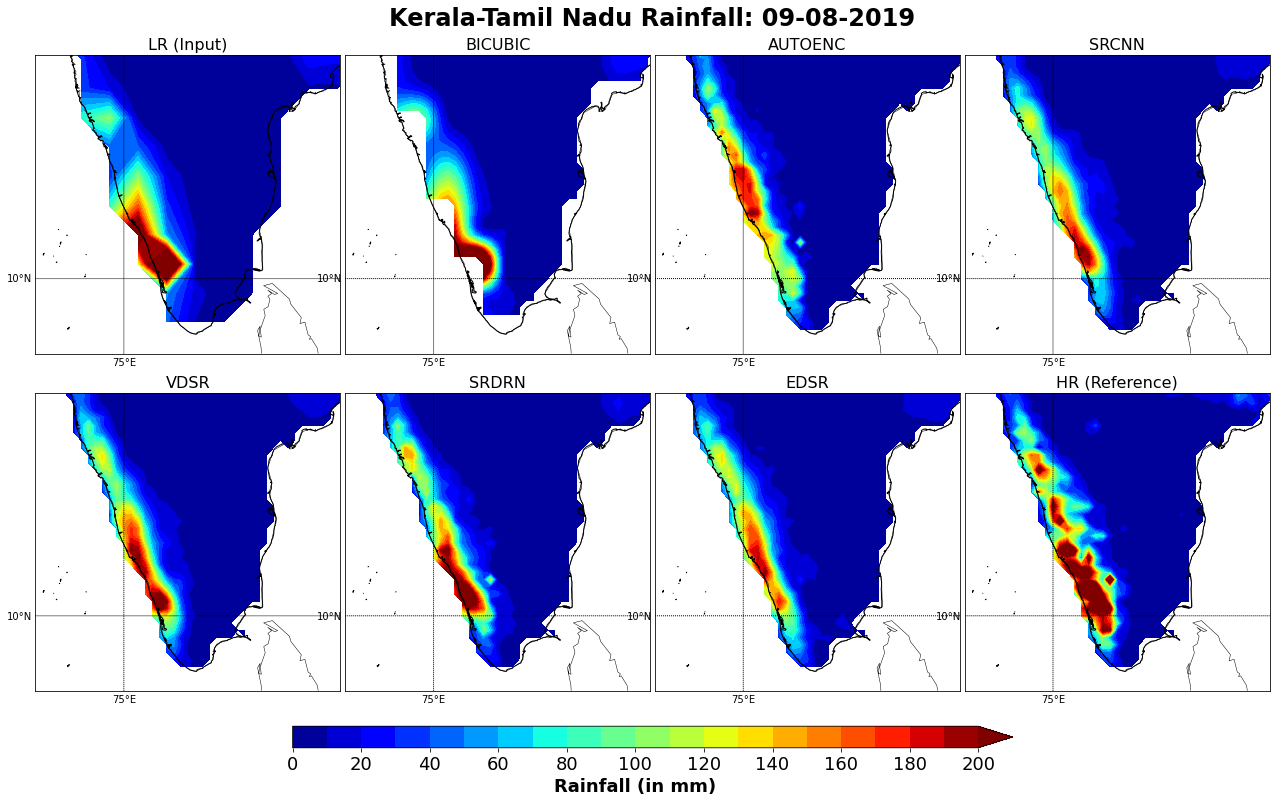

In [6]:
# Plotting code for Figure-5 b)
bm=Basemap(projection='merc',llcrnrlat=7.4,urcrnrlat=17.6,llcrnrlon=71.9,urcrnrlon=82.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1316
fig= plt.figure(figsize=(20,10), facecolor = 'white')

fig.suptitle('Kerala-Tamil Nadu Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
  ax = fig.add_subplot(subplot)
  ax.set_title(x, fontsize=16)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
  bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()   

<ipython-input-7-c62b7fadf3bf>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


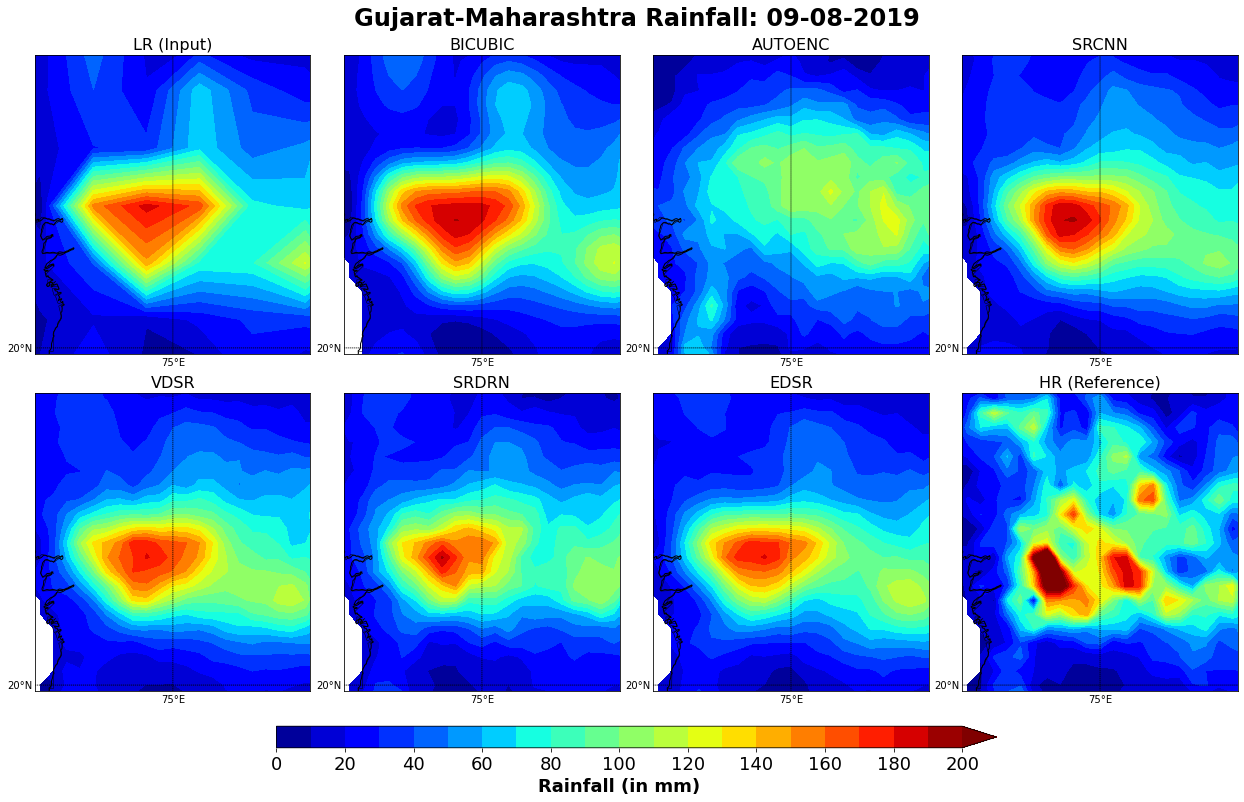

In [7]:
# Plotting code for Figure-5 c)
bm=Basemap(projection='merc',llcrnrlat=19.9,urcrnrlat=25.1,llcrnrlon=72.4,urcrnrlon=77.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1316
fig= plt.figure(figsize=(20,10), facecolor = 'white')

fig.suptitle('Gujarat-Maharashtra Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
  ax = fig.add_subplot(subplot)
  ax.set_title(x, fontsize=16)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
  bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()   

In [8]:
# Saving all the outputs along with groundtruth (gt) into a netCDF file.
ds = xr.Dataset(
    {"gt": (("time", "lat", "lon"), groundtruths*mask_025.reshape((1, 128, 128))),
     "autoenc": (("time", "lat", "lon"), outputs['AUTOENC']*mask_025.reshape((1, 128, 128))),
     "srcnn": (("time", "lat", "lon"), outputs['SRCNN']*mask_025.reshape((1, 128, 128))),
     "vdsr": (("time", "lat", "lon"), outputs['VDSR']*mask_025.reshape((1, 128, 128))),
     "srdrn": (("time", "lat", "lon"), outputs['SRDRN']*mask_025.reshape((1, 128, 128))),
     "edsr": (("time", "lat", "lon"), outputs['EDSR']*mask_025.reshape((1, 128, 128))),
     "bic": (("time", "lat", "lon"), outputs['BICUBIC']*mask_025.reshape((1, 128, 128))),
     },
    coords={
        "time": other['dates'],
        "lat": other['lat_025'],
        "lon": other['lon_025'],
    },
)
ds.to_netcdf('./SISR_Outputs.nc')

In [9]:
# Plotting Figure-4
# Calculating fieldmean over the domain for each variable in the SISR_Outputs.nc file for KDE plot.
!cdo fldmean ./SISR_Outputs.nc ./SISR_Outputs_FLDMEAN.nc

cdo    fldmean: Processed 7 variables over 2192 timesteps [2.00s 4367MB].
free(): invalid pointer


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

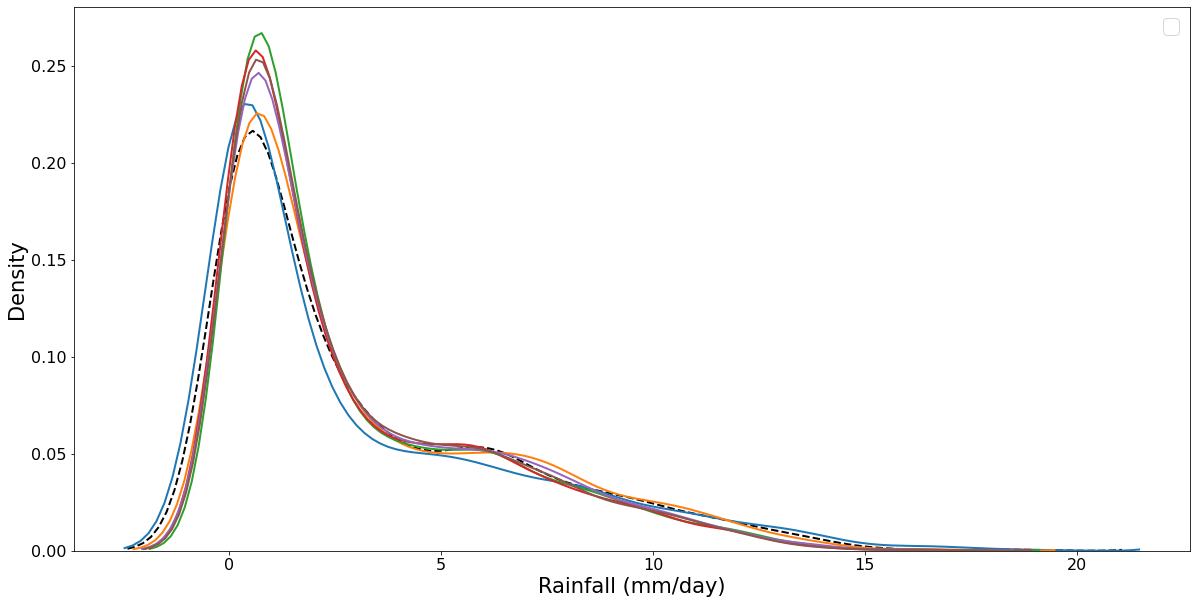

In [10]:
fldmean = xr.open_dataset('./SISR_Outputs_FLDMEAN.nc')
plt.figure(figsize = (20,10), facecolor = 'white')
sns.kdeplot(list(np.squeeze(fldmean.gt.values)), linestyle = '--', color = 'black', lw = 2)
sns.kdeplot(fldmean.bic.values[:,0,0], lw = 2)
sns.kdeplot(fldmean.autoenc.values[:,0,0], lw = 2)
sns.kdeplot(fldmean.srcnn.values[:,0,0], lw = 2)
sns.kdeplot(fldmean.vdsr.values[:,0,0], lw = 2)
sns.kdeplot(fldmean.srdrn.values[:,0,0], lw = 2)
sns.kdeplot(fldmean.edsr.values[:,0,0], lw = 2)
plt.legend(['HR', 'BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR'], prop={'size': 21})
plt.xlabel('Rainfall (mm/day)', fontsize = 21)
plt.ylabel('Density', fontsize = 21)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

In [11]:
# Using the SISR_Outputs.nc file, the spatial correlations between the rainfall timeseries at each grid box were calculated using CDO.
# Commmand used: cdo timcor -selvar,<var1> ./SISR_Outputs.nc -selvar,<var2> ./SISR_Outputs.nc ./Correlations/<model>_corr.nc

<ipython-input-13-b7981d3840ee>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


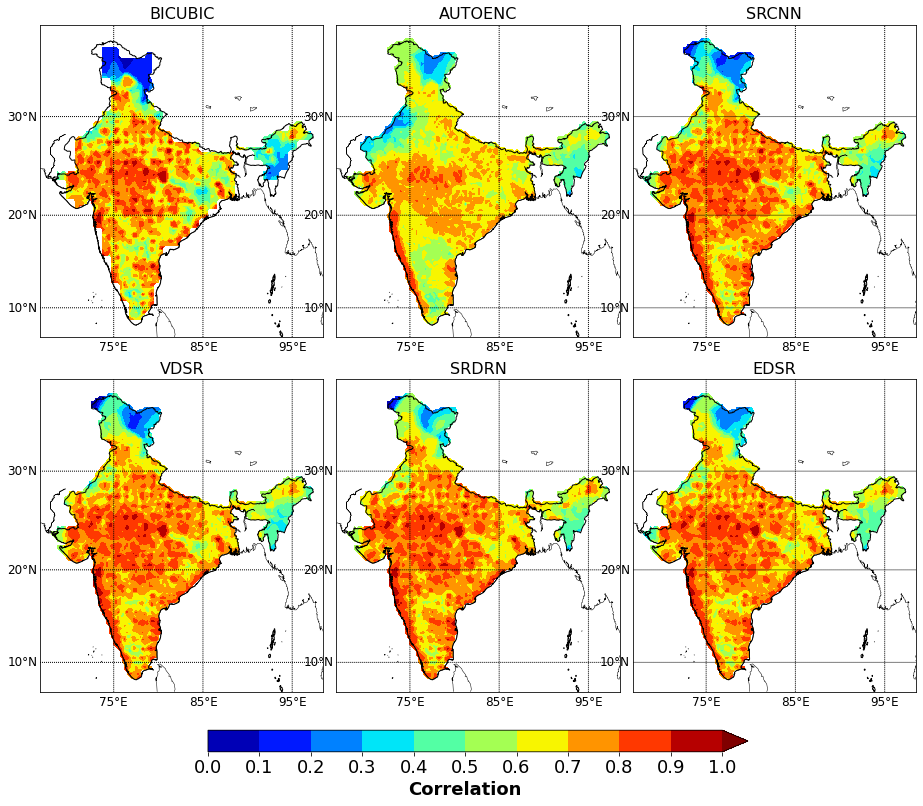

In [13]:
# Plotting Figure 3: correlation maps.
# Basemap Plots
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

xi, yi = bm(lons_025, lats_025)

fig= plt.figure(figsize=(15,10), facecolor = 'white')
subplot = 231
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
  ax = fig.add_subplot(subplot)
  ax.set_title(x, fontsize=16)
  corr_bicubic = xr.open_dataset('./Correlations/'+x+'_corr.nc').gt.values
  colormap = bm.contourf(xi,yi,np.squeeze(corr_bicubic*mask_025), contour_levels, cmap='jet', extend = 'max')
  bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False], fontsize=12)
  bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize=12)
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Correlation', weight='bold', size = 18)
fig.tight_layout()

## **Calculating Error Metrics**

In [14]:
# Flatten and remove NaN values.
def flat_nan_rem(arr):
  # Setting all existing nan values to zero first to ensure all the flattened arrays (post-nan removal) are of same shape
  arr = np.where(np.isnan(arr),0,arr)
  arr = (arr*mask_025).flatten()
  return arr[np.where(~np.isnan(arr))]

In [15]:
# Defining all the metrics.

def correlation_coefficient(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the covariance and the standard deviations of the two arrays
    cov = np.cov(model, gt)
    std_model = np.std(model)
    std_gt = np.std(gt)
    # Calculate the correlation coefficient
    corr_coef = cov[0][1] / (std_model * std_gt)
    return np.round(corr_coef, 4)

def mean_absolute_error(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the absolute differences between the values in the two arrays
    abs_diff = np.abs(model - gt)
    # Calculate the mean absolute error
    mae = np.mean(abs_diff)
    return np.round(mae, 4)

def root_mean_square_error(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the squared differences between the values in the two arrays
    sq_diff = (model - gt) ** 2
    # Calculate the root mean square error
    rmse = np.sqrt(np.mean(sq_diff))
    return np.round(rmse,4)

def coefficient_of_determination(model, gt):
    # Calculate the correlation coefficient between the two arrays
    corr_coef = correlation_coefficient(model, gt)
    # Calculate the coefficient of determination
    r_squared = corr_coef ** 2
    return np.round(r_squared, 4)

def bias(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the difference between the values in the two arrays
    diff = model - gt
    # Calculate the bias
    bias = np.mean(diff)
    return np.round(bias,4)

def psnr(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # calculate the MSE
    mse = np.mean((model - gt) ** 2)
    # calculate the maximum pixel value
    max_pixel = np.max(gt)
    # calculate the PSNR
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return np.round(psnr,4)

def percent_bias(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the mean of the observed values and the modeled values
    obs_mean = np.mean(gt)
    model_mean = np.mean(model)
    # Calculate the difference between the modeled values and the observed values
    diff = model - gt
    # Calculate the sum of the differences
    diff_sum = np.sum(diff)
    # Calculate the sum of the observed values
    obs_sum = np.sum(gt)
    # Calculate the percent bias
    pbias = 100 * (diff_sum / obs_sum)
    return np.round(pbias,4)

def cosine_similarity(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the dot product of the two arrays
    dot_product = np.dot(model, gt) 
    # Calculate the magnitudes of the two arrays
    model_mag = np.sqrt(np.sum(model**2))
    gt_mag = np.sqrt(np.sum(gt**2)) 
    # Calculate the cosine similarity
    cosine_sim = dot_product / (model_mag * gt_mag)
    return np.round(cosine_sim, 4)

In [16]:
# Defining error metrics table.
df = pd.DataFrame(columns = ['Model', 'r', 'MAE', 'RMSE', 'r^2', 'Bias', 'PBIAS', 'PSNR', 'Cosine Similarity'])
# Function to calculate all metrics at same time for a particular model output-gt combination.
def calc_metrics(exp, model, obs, df):
    df.loc[len(df)] = [exp, correlation_coefficient(model, obs), mean_absolute_error(model, obs), root_mean_square_error(model, obs), 
               coefficient_of_determination(model, obs), bias(model, obs), percent_bias(model, obs), psnr(model, obs), cosine_similarity(model, obs)]
# Calculating the metrics.
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
  calc_metrics(x, outputs[x], groundtruths, df)

In [17]:
df

,Model,r,MAE,RMSE,r^2,Bias,PBIAS,PSNR,Cosine Similarity
0,BICUBIC,0.5361,2.9787,10.0752,0.2874,-0.4314,-13.5123,36.5044,0.5713
1,AUTOENC,0.6726,3.0028,8.1816,0.4524,0.0662,2.0728,38.3127,0.7032
2,SRCNN,0.7065,2.6550,7.8441,0.4991,-0.2323,-7.2757,38.6786,0.7333
3,VDSR,0.7102,2.5793,7.8039,0.5044,-0.2935,-9.1952,38.7232,0.7365
4,SRDRN,0.7288,2.5609,7.5796,0.5311,-0.1595,-4.9961,38.9765,0.7531
5,EDSR,0.7181,2.6040,7.7188,0.5157,-0.2325,-7.2841,38.8184,0.7435


In [18]:
# Saving these metrics to a .csv file.
df.to_csv('./SISR_Error_Metrics.csv')

### **Supplementary Figures**

<ipython-input-19-21fbc404afc4>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


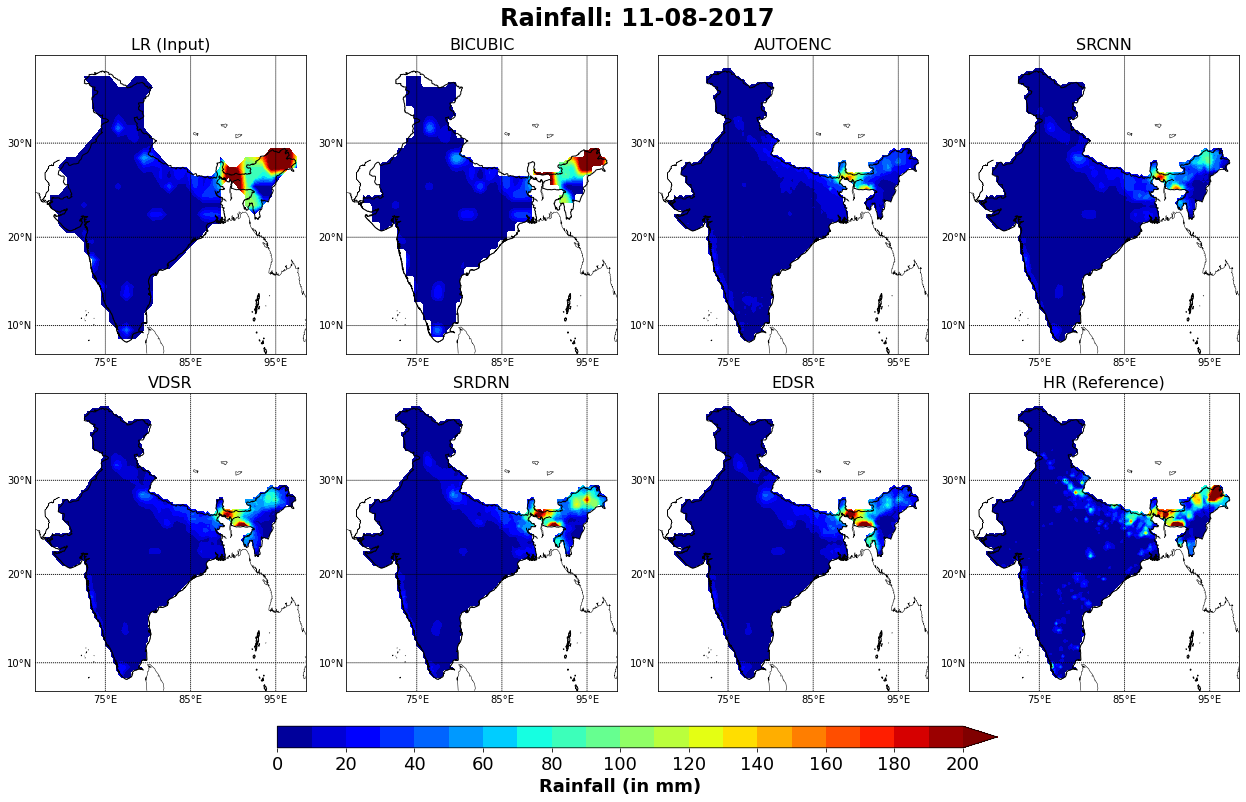

In [19]:
# Plotting Supplementary Figures
# Figure S1 a)
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 588
fig= plt.figure(figsize=(20,10), facecolor = 'white')

fig.suptitle('Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
            fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
    ax = fig.add_subplot(subplot)
    ax.set_title(x, fontsize=16)
    bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
    bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
    bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
    bm.drawcoastlines(linewidth=0.5)
    bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
    subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()     

<ipython-input-20-41277c538462>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


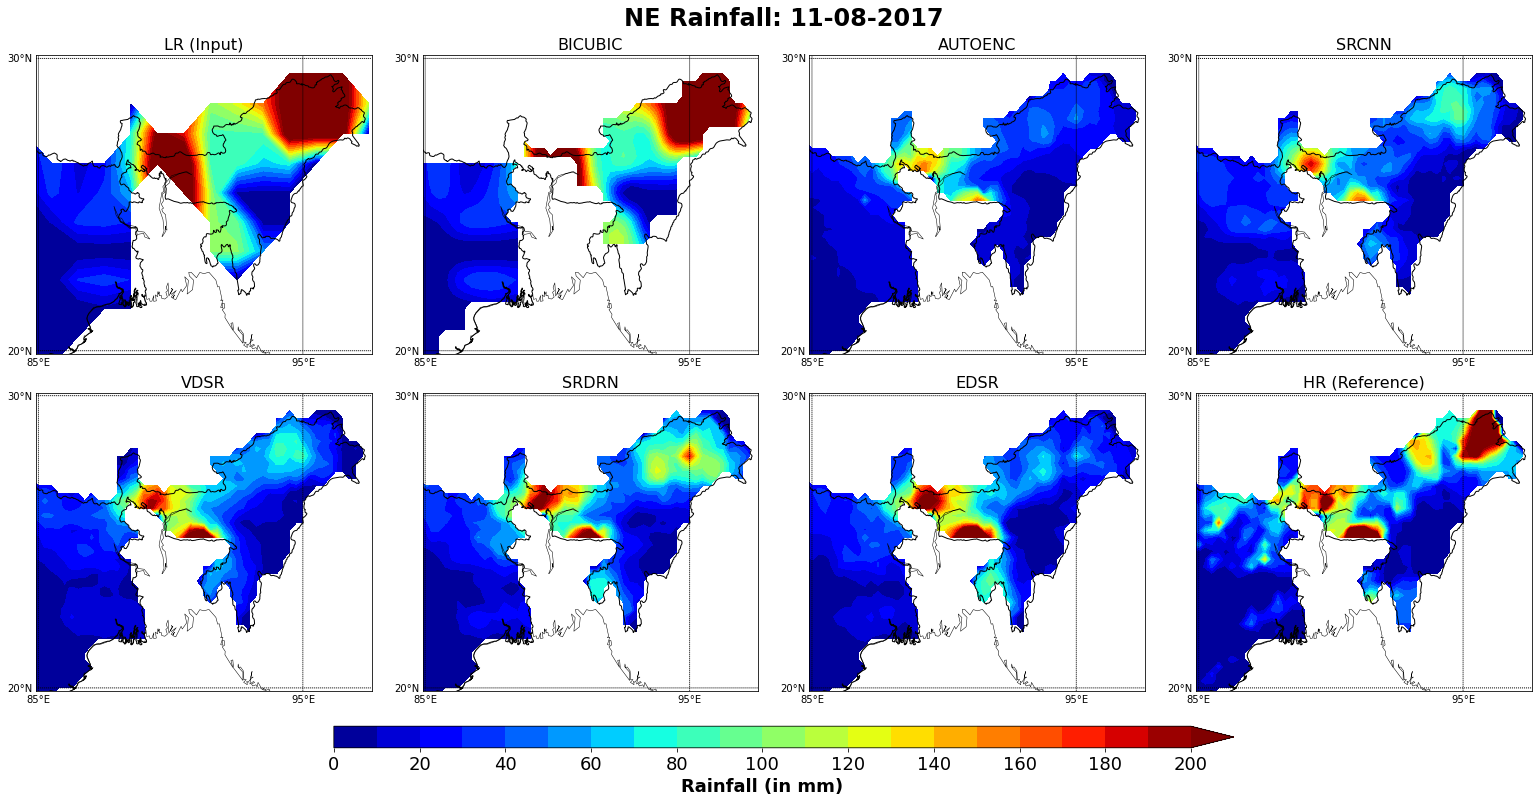

In [20]:
# Figure S1 b)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=19.9,urcrnrlat=30.1,llcrnrlon=84.9,urcrnrlon=97.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 588
fig= plt.figure(figsize=(25,10), facecolor = 'white')

fig.suptitle('NE Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
  ax = fig.add_subplot(subplot)
  ax.set_title(x, fontsize=16)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
  bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout() 

<ipython-input-21-25345d882655>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


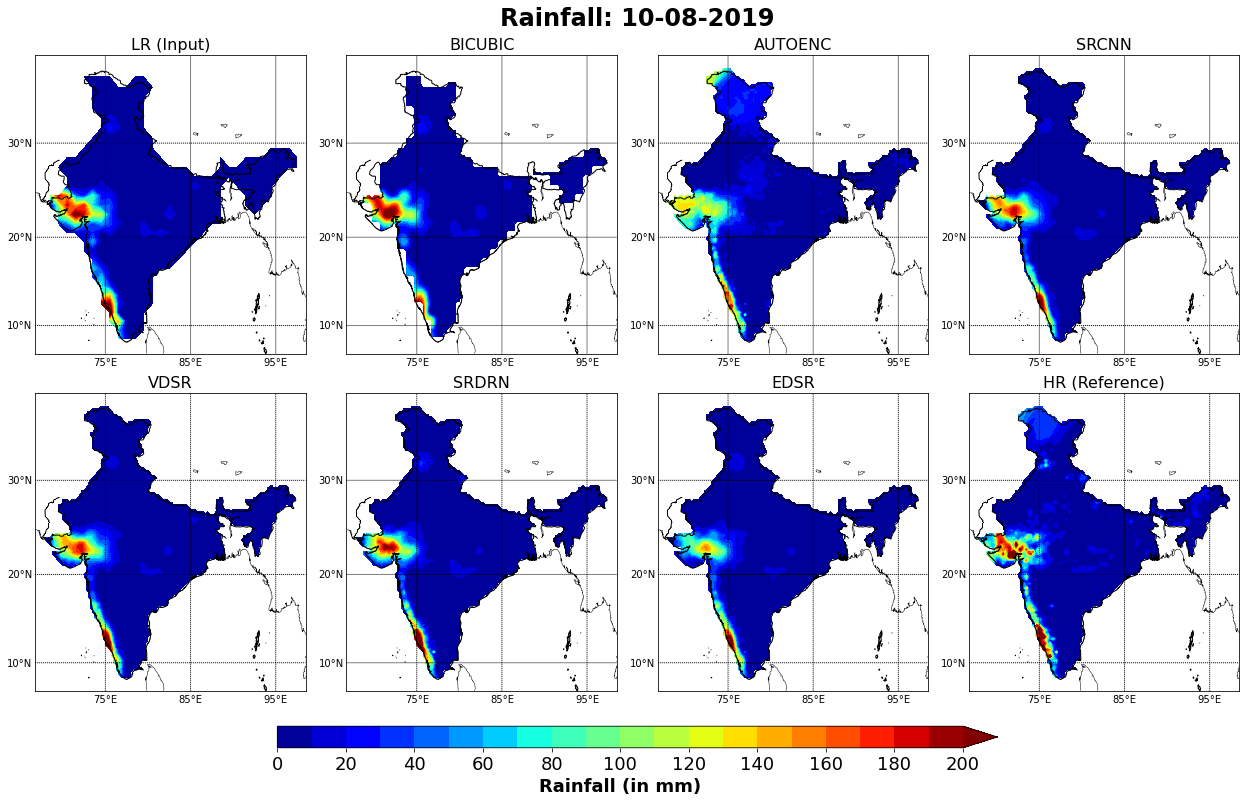

In [21]:
# Plotting Supplementary Figures
# Figure S2 a)
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1317
fig= plt.figure(figsize=(20,10), facecolor = 'white')

fig.suptitle('Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
            fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
    ax = fig.add_subplot(subplot)
    ax.set_title(x, fontsize=16)
    bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
    bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
    bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
    bm.drawcoastlines(linewidth=0.5)
    bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
    subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()     

<ipython-input-23-9ed3150e8f42>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


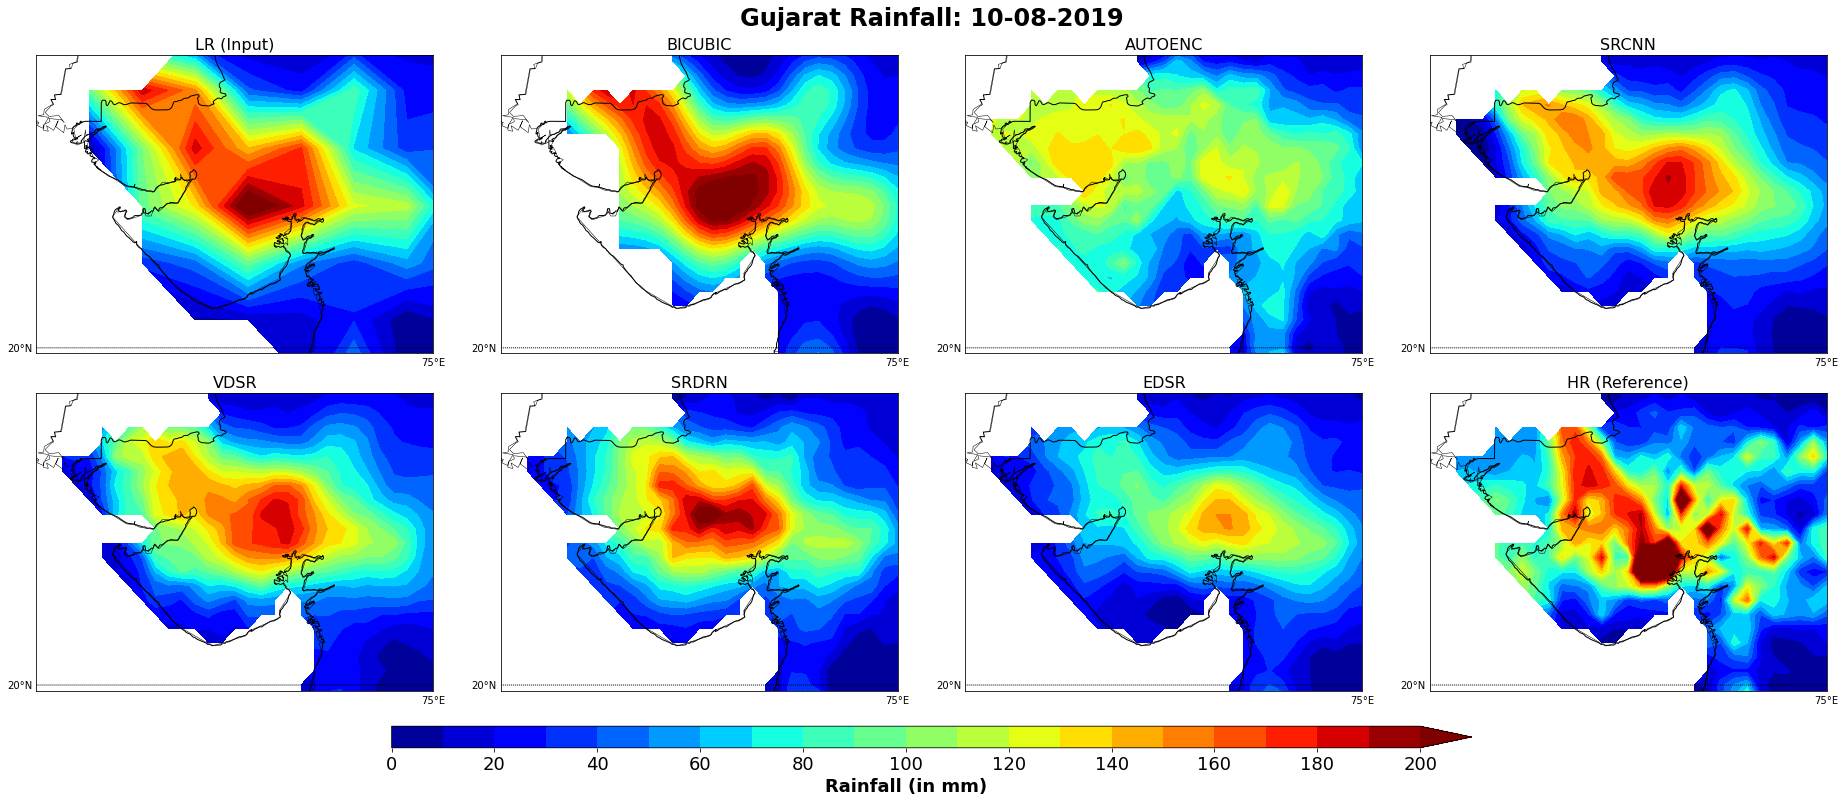

In [23]:
# Figure S2 b)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=19.9,urcrnrlat=25.1,llcrnrlon=67.5,urcrnrlon=75, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1317
fig= plt.figure(figsize=(30,10), facecolor = 'white')

fig.suptitle('Gujarat Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
  ax = fig.add_subplot(subplot)
  ax.set_title(x, fontsize=16)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
  bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()   

<ipython-input-22-b06d02019630>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


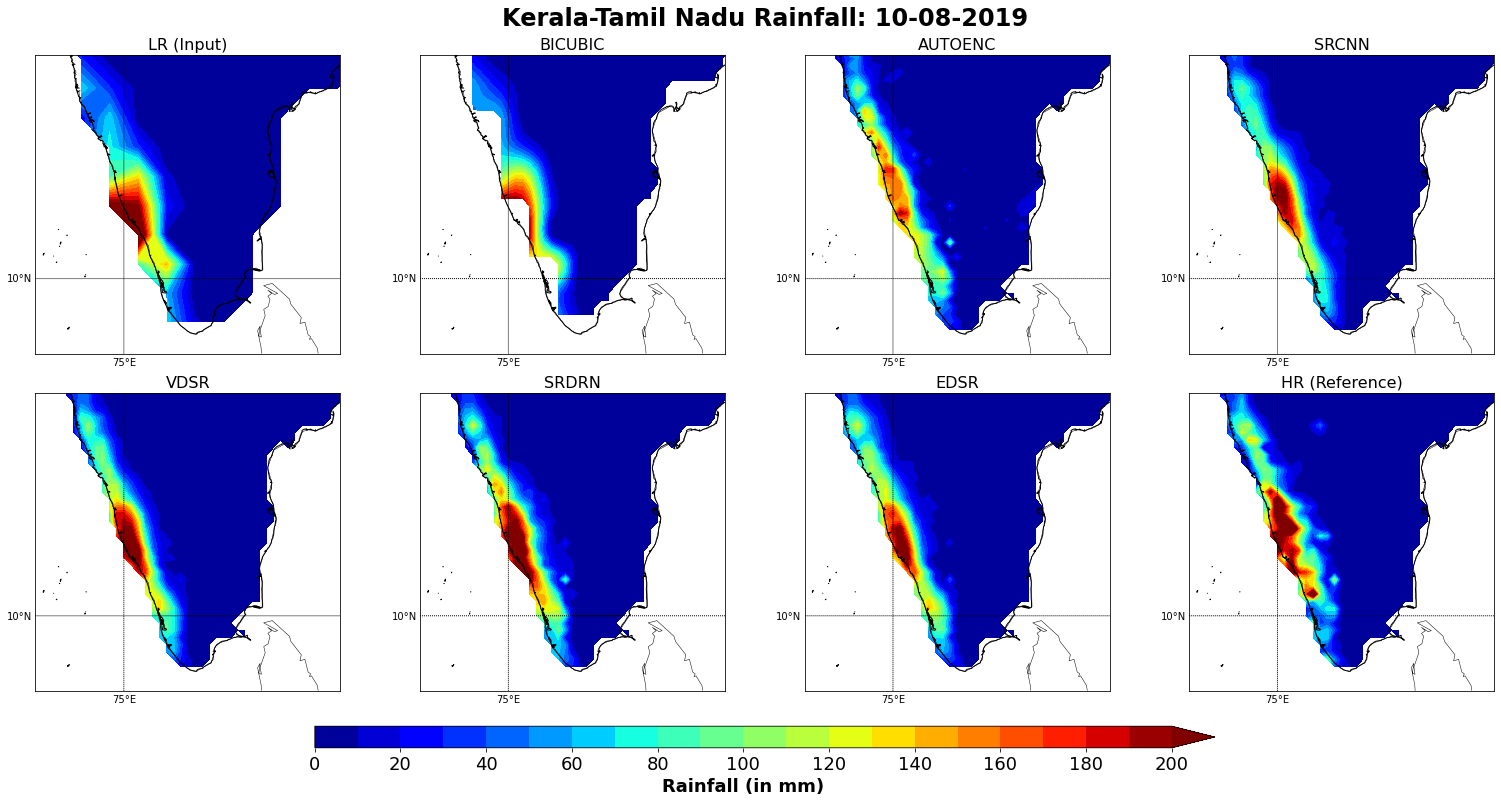

In [22]:
# Figure S2 c)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=7.4,urcrnrlat=17.6,llcrnrlon=71.9,urcrnrlon=82.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1317
fig= plt.figure(figsize=(25,10), facecolor = 'white')

fig.suptitle('Kerala-Tamil Nadu Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
  ax = fig.add_subplot(subplot)
  ax.set_title(x, fontsize=16)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
  bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()   

<ipython-input-24-ae57a89763a3>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


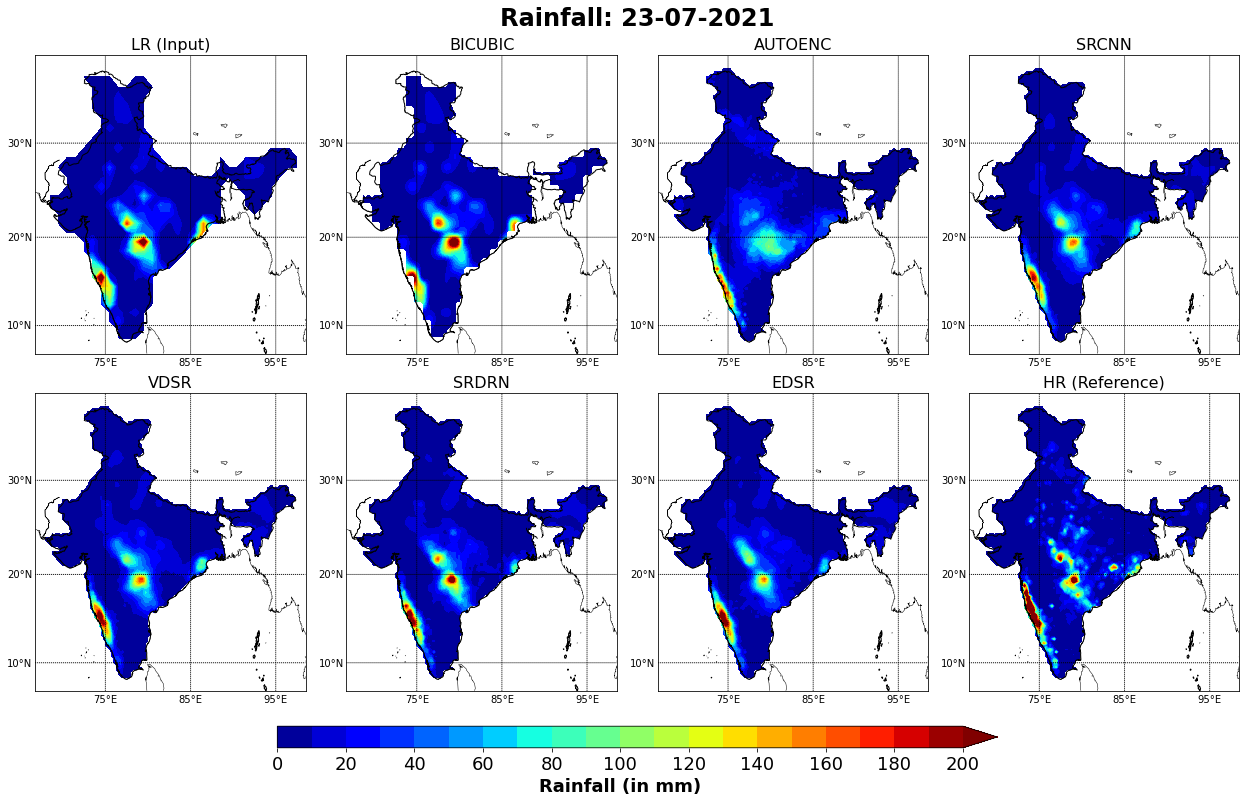

In [24]:
# Plotting Supplementary Figures
# Figure S3 a)
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 2030
fig= plt.figure(figsize=(20,10), facecolor = 'white')

fig.suptitle('Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
            fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
    ax = fig.add_subplot(subplot)
    ax.set_title(x, fontsize=16)
    bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
    bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
    bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
    bm.drawcoastlines(linewidth=0.5)
    bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
    subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()     

<ipython-input-25-884bde6f6d68>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


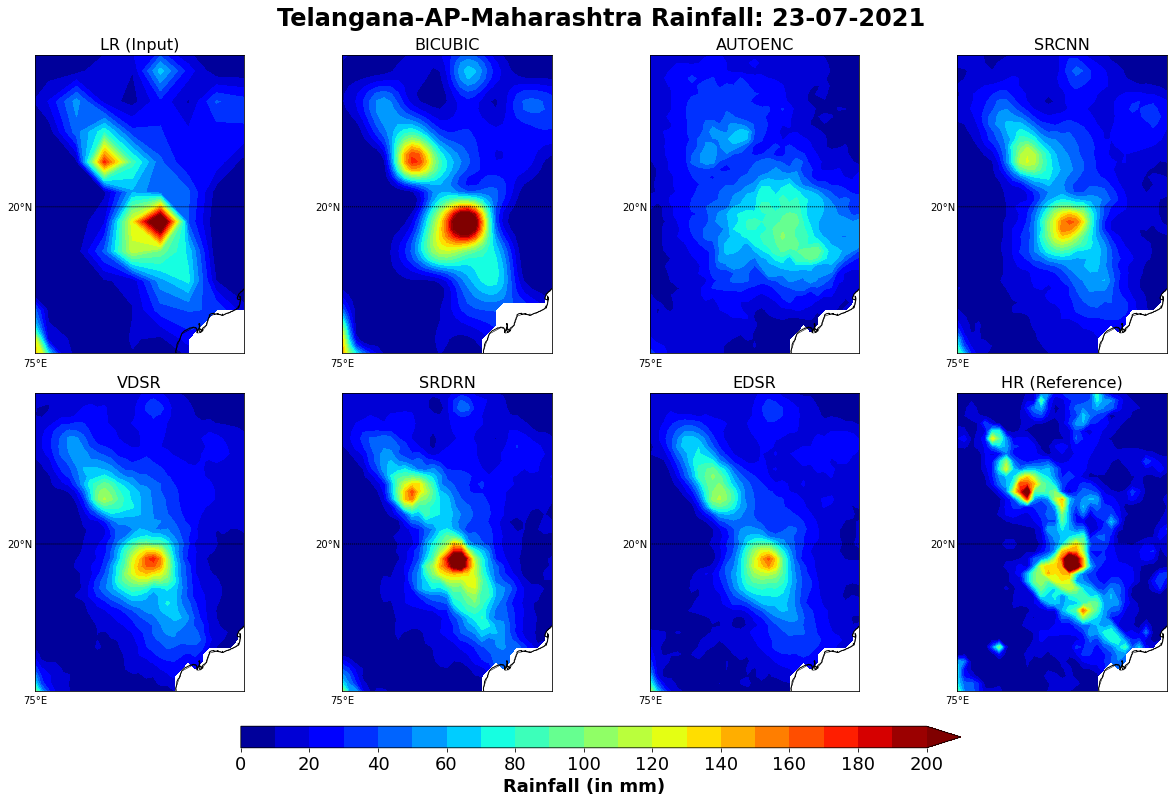

In [25]:
# Figure S3 b)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=15,urcrnrlat=25,llcrnrlon=75,urcrnrlon=82.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 2030
fig= plt.figure(figsize=(20,10), facecolor = 'white')

fig.suptitle('Telangana-AP-Maharashtra Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
  ax = fig.add_subplot(subplot)
  ax.set_title(x, fontsize=16)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
  bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()   

<ipython-input-26-fceec267f2d5>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


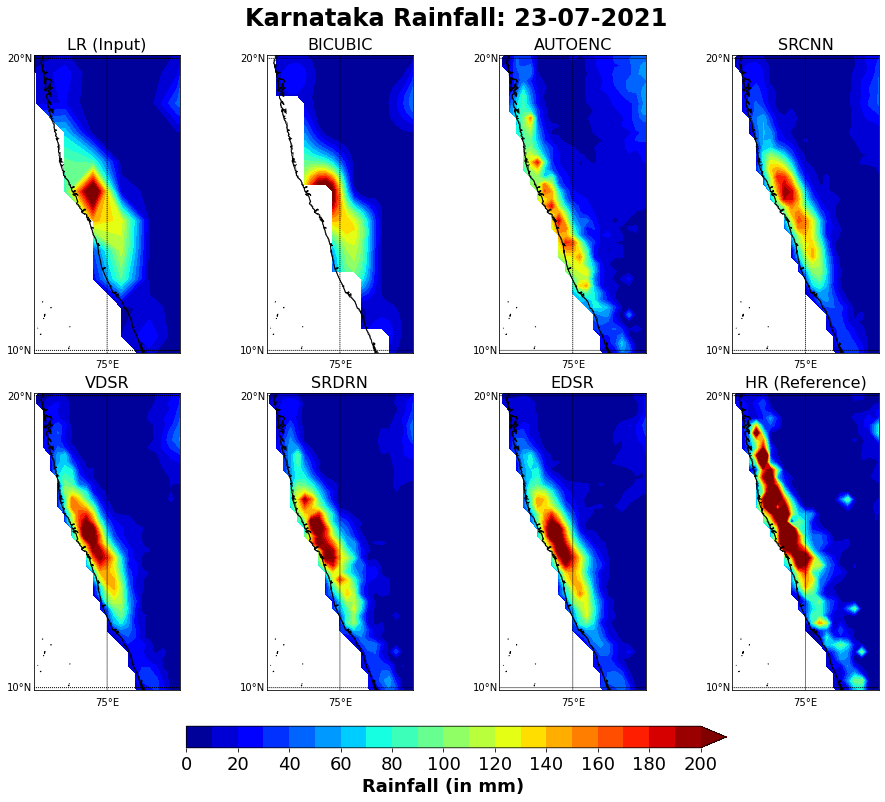

In [26]:
# Figure S3 c)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=9.9,urcrnrlat=20.1,llcrnrlon=72.4,urcrnrlon=77.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 2030
fig= plt.figure(figsize=(15,10), facecolor = 'white')

fig.suptitle('Karnataka Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(241)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 242
for x in ['BICUBIC', 'AUTOENC', 'SRCNN', 'VDSR', 'SRDRN', 'EDSR']:
  ax = fig.add_subplot(subplot)
  ax.set_title(x, fontsize=16)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
  bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(248)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True])
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True])
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()   



---


In [ ]:
!pip freeze > environment.txt